# Capstone Project - George Lawson

For this project I will be showing an example of natural language processing. The aim is to create a fuction that takes in a quote and outputs wheather or not Sheldon from The Big Bang Theory said that quote or not. 

In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter


import itertools
from collections import Counter
import re
import string

!pip install wordcloud
from wordcloud import WordCloud, ImageColorGenerator


import nltk 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import TfidfVectorizer

import statsmodels.api as sm
import statsmodels.tools 

from sklearn import metrics
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_curve, auc

from sklearn.utils import resample

nltk.download('stopwords') ##these are lookup libraries
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\georg\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\georg\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\georg\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
os.chdir("C:\\Users\georg\OneDrive\Documents\Digital Futures\Datasets")
df = pd.read_csv("1_10_seasons_tbbt.csv")

# 1. Exploring and Cleaning the Data

In [3]:
df.head(10)

,episode_name,dialogue,person_scene
0,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Scene
1,Series 01 Episode 01 – Pilot Episode,So if a photon is directed through a plane wi...,Sheldon
2,Series 01 Episode 01 – Pilot Episode,"Agreed, what’s your point?",Leonard
3,Series 01 Episode 01 – Pilot Episode,"There’s no point, I just think it’s a good id...",Sheldon
4,Series 01 Episode 01 – Pilot Episode,Excuse me?,Leonard
5,Series 01 Episode 01 – Pilot Episode,Hang on.,Receptionist
6,Series 01 Episode 01 – Pilot Episode,"One across is Aegean, eight down is Nabakov, ...",Leonard
7,Series 01 Episode 01 – Pilot Episode,Can I help you?,Receptionist
8,Series 01 Episode 01 – Pilot Episode,"Yes. Um, is this the High IQ sperm bank?",Leonard
9,Series 01 Episode 01 – Pilot Episode,"If you have to ask, maybe you shouldn’t be here.",Receptionist


In [4]:
df.shape

(54406, 3)

In [5]:
df.dtypes

episode_name    object
dialogue        object
person_scene    object
dtype: object

To begin with we look at the different values for the person__scene column, this is the column that states which character spoke the given lines.

In [6]:
len(df['person_scene'].unique())

606

In [7]:
df['person_scene'].unique()

array(['Scene', 'Sheldon', 'Leonard', 'Receptionist', 'Penny', '(mouths)',
       'back)', 'Howard', 'Raj', 'Raj)', 'buzzer)', 'buzzer', 'Voice',
       'man', 'Man', '(sings)', '(off)', 'together', '(snarkily)',
       '(entering)', 'likewise)', 'off)', 'door)', 'talk)',
       '(internally)', 'mat)', 'him)', 'ear)', 'Teleplay', 'Story',
       'hallway)', 'Doug', 'Lesley', 'instructor', 'Leonard)',
       '(singing)', 'Waitress', 'Summer', 'Sheldon)', 'Gablehouser',
       'round)', 'supplements)', 'Cooper', 'Cooper)', 'chair)',
       '(leaving)', 'quartettist', 'room)', 'apartment)', '(inside)',
       '(arriving)', 'costume)', 'All', 'Thor)', 'off-screen)', 'Girl',
       'Costume', 'Kurt', 'ground)', 'entering)', 'doorway)', 'phone',
       'television)', 'again)', 'Christie', 'Waiter', '(answering)',
       '(voice)', 'within)', 'women)', 'Koothrappali', 'Together',
       'gather)', 'phone)', 'Lalita', 'Penny)', 'embarrassed)',
       'mailbox)', 'glasses)', 'down)', 'floor)', 

We can see that there are 606 different values in this column however looking at the values we can see there are some that are just spelling mistakes of each other, e.g., 'Sheldon', 'Sehldon', 'Shldon' and 'Shedon' are all supposed to be the same. We will need to take care of this. 'Cooper' also 'Sheldon'

There are some cases where there are perenthesis withing the person_scene which is causing some duplicate answers.

In [8]:
for i in range(len(df)):
    df.iloc[i]['person_scene'] = df.iloc[i]['person_scene'].replace('(','').replace(')','')

In [9]:
len(df['person_scene'].unique())

564

By just removing the parentheses we have go rid of 42 duplicates. Now to deal with the spelling mistakes or issue of switching between using last name and first name.

In [10]:
df['person_scene'].unique()

array(['Scene', 'Sheldon', 'Leonard', 'Receptionist', 'Penny', 'mouths',
       'back', 'Howard', 'Raj', 'buzzer', 'Voice', 'man', 'Man', 'sings',
       'off', 'together', 'snarkily', 'entering', 'likewise', 'door',
       'talk', 'internally', 'mat', 'him', 'ear', 'Teleplay', 'Story',
       'hallway', 'Doug', 'Lesley', 'instructor', 'singing', 'Waitress',
       'Summer', 'Gablehouser', 'round', 'supplements', 'Cooper', 'chair',
       'leaving', 'quartettist', 'room', 'apartment', 'inside',
       'arriving', 'costume', 'All', 'Thor', 'off-screen', 'Girl',
       'Costume', 'Kurt', 'ground', 'doorway', 'phone', 'television',
       'again', 'Christie', 'Waiter', 'answering', 'voice', 'within',
       'women', 'Koothrappali', 'Together', 'gather', 'Lalita',
       'embarrassed', 'mailbox', 'glasses', 'down', 'floor', 'captions',
       'two', 'one', 'tunelessly', 'Toby', 'duvet', 'stairs', 'Mother',
       'clearance', 'sigh', 'teeth', 'vaporub', 'Dennis', 'dramatically',
       'tu

In [11]:
sheldon_names = ['Sheldon','Cooper','Sheldon-bot', 'Sgeldon','Sehldon', 'Shldon', 'Shedon']

df['person_scene'] = df['person_scene'].map(lambda x: 'Sheldon' if x in sheldon_names else x)

In [12]:
person = df.groupby('person_scene')[['dialogue']].count().sort_values(['dialogue'],ascending=False).reset_index()
person.rename(columns = {'dialogue':'number_of_scenes'}, inplace=True)
person['%'] = round(person['number_of_scenes'] / len(df) *100,2)
person.head(10)

,person_scene,number_of_scenes,%
0,Sheldon,11732,21.56
1,Leonard,9644,17.73
2,Penny,7480,13.75
3,Howard,5741,10.55
4,Raj,4589,8.43
5,Amy,3419,6.28
6,Scene,2850,5.24
7,Bernadette,2636,4.85
8,Stuart,726,1.33
9,off,243,0.45


We can see that Sheldon has the most scenes and that his scenes make up 21.56% of our data.

In [13]:
main_characters = ['Sheldon', 'Leonard', 'Penny', 'Howard', 'Raj', 'Amy', 'Bernadette', 'Stuart', 'Scene']

person['person_scene'] = person['person_scene'].map(lambda x: x if x in main_characters else 'Other')

In [14]:
percentage = person.groupby('person_scene')[['%']].sum().sort_values(['%'],ascending = False).reset_index()
percentage

,person_scene,%
0,Sheldon,21.56
1,Leonard,17.73
2,Penny,13.75
3,Howard,10.55
4,Other,9.73
5,Raj,8.43
6,Amy,6.28
7,Scene,5.24
8,Bernadette,4.85
9,Stuart,1.33


Note: included in the 'Other' group for person_scene is the spelling mistakes of the other actors names so should probably clean these in a similar way (I will onl do this for main characters though).

In [15]:
Leonard_names = ['Leonard','Leonard-warrior', 'Hofstadter', 'Leonard:', 'Leoanard']
df['person_scene'] = df['person_scene'].map(lambda x: 'Leonard' if x in Leonard_names else x)

In [16]:
Raj_names = ['Raj', 'Koothrappali', 'Rai', 'Rajj', 'Ra', 'Koothrapalli']
df['person_scene'] = df['person_scene'].map(lambda x: 'Raj' if x in Raj_names else x)

In [17]:
Howard_names = ['Howard', 'Wolowitz', 'Howatd']
df['person_scene'] = df['person_scene'].map(lambda x: 'Raj' if x in Raj_names else x)
###there isn't much need to do the others as doing this is only for the purpose of visualising the data.
###only the ones relating to Sheldon actually need to be done.

In [18]:
percentage = person.groupby('person_scene')[['%']].sum().sort_values(['%'],ascending = False).reset_index()
percentage.rename(columns={'person_scene':'Character'},inplace=True)
percentage

,Character,%
0,Sheldon,21.56
1,Leonard,17.73
2,Penny,13.75
3,Howard,10.55
4,Other,9.73
5,Raj,8.43
6,Amy,6.28
7,Scene,5.24
8,Bernadette,4.85
9,Stuart,1.33


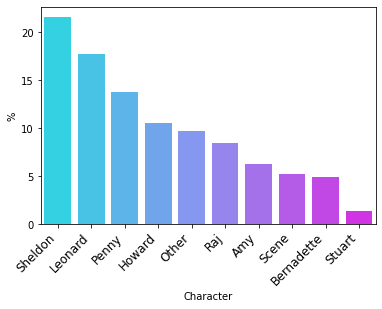

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111)
sns.barplot(data = percentage,
           x = 'Character',
           y = '%',
           palette = 'cool'
           )
# plt.yticks(color='white')
    
plt.xticks(rotation = 45,
          horizontalalignment = 'right',
          fontweight = 'light',
          fontsize = 'large'
          #color = 'white'
          )
# ax.xaxis.label.set_color('white')
# ax.yaxis.label.set_color('white')
# ax.spines['bottom'].set_color('white')
# ax.spines['top'].set_color('white')
# ax.spines['left'].set_color('white')
# ax.spines['right'].set_color('white')
plt.show()

Now would be a good time to check if there are any duplicate rows in the dataframe.

In [23]:
len(df)

54406

In [24]:
df.drop_duplicates

<bound method DataFrame.drop_duplicates of                                             episode_name  \
0                   Series 01 Episode 01 – Pilot Episode   
1                   Series 01 Episode 01 – Pilot Episode   
2                   Series 01 Episode 01 – Pilot Episode   
3                   Series 01 Episode 01 – Pilot Episode   
4                   Series 01 Episode 01 – Pilot Episode   
...                                                  ...   
54401  Series 10 Episode 24 – The Long Distance Disso...   
54402  Series 10 Episode 24 – The Long Distance Disso...   
54403  Series 10 Episode 24 – The Long Distance Disso...   
54404  Series 10 Episode 24 – The Long Distance Disso...   
54405  Series 10 Episode 24 – The Long Distance Disso...   

                                                dialogue person_scene  
0                            A corridor at a sperm bank.        Scene  
1       So if a photon is directed through a plane wi...      Sheldon  
2                   

In [25]:
len(df)

54406

So there were no duplicate rows.

Now to check if there are any null values in our dataset

In [26]:
df.isna().sum()

episode_name    0
dialogue        2
person_scene    0
dtype: int64

So there are only two null values and they are both in the dialogue column. I will probably drop those rows but will first have a look at them.

In [27]:
df.loc[df['dialogue'].isna()]

,episode_name,dialogue,person_scene
8845,Series 02 Episode 19 – The Dead Hooker Juxtapo...,NaN,Penny
52444,Series 10 Episode 17 – The Comic-Con Conundrum,NaN,sequence


In [28]:
df = df.loc[~df['dialogue'].isna()]

In [29]:
df.shape

(54404, 3)

The two rows containing null values have now been dropped.

The first column in the dataframe, showing which episode and season the dialogue is from, is not relevant to this project so will be dropped.

In [30]:
df = df[['dialogue','person_scene']]

I will also change the name of the column showing the character speaking to character.

In [31]:
df.rename(columns = {'person_scene':'character'},inplace=True)

In [32]:
df.head(10)

,dialogue,character
0,A corridor at a sperm bank.,Scene
1,So if a photon is directed through a plane wi...,Sheldon
2,"Agreed, what’s your point?",Leonard
3,"There’s no point, I just think it’s a good id...",Sheldon
4,Excuse me?,Leonard
5,Hang on.,Receptionist
6,"One across is Aegean, eight down is Nabakov, ...",Leonard
7,Can I help you?,Receptionist
8,"Yes. Um, is this the High IQ sperm bank?",Leonard
9,"If you have to ask, maybe you shouldn’t be here.",Receptionist


Now to create a binary column showing if the character speaking is Sheldon or not, where 1=Sheldon and 0=Not Sheldon.

In [33]:
sheldon_binary = []
for i in range(len(df)):
    if df.iloc[i]['character'] == 'Sheldon':
        sheldon_binary.append(1)
    else:
        sheldon_binary.append(0)

df['Sheldon'] = sheldon_binary

In [34]:
df.head(10)

,dialogue,character,Sheldon
0,A corridor at a sperm bank.,Scene,0
1,So if a photon is directed through a plane wi...,Sheldon,1
2,"Agreed, what’s your point?",Leonard,0
3,"There’s no point, I just think it’s a good id...",Sheldon,1
4,Excuse me?,Leonard,0
5,Hang on.,Receptionist,0
6,"One across is Aegean, eight down is Nabakov, ...",Leonard,0
7,Can I help you?,Receptionist,0
8,"Yes. Um, is this the High IQ sperm bank?",Leonard,0
9,"If you have to ask, maybe you shouldn’t be here.",Receptionist,0


# Lemmatize

In [35]:
def regex_clean(txt, regex):
    """Replace any text matching the regex

    Parameters
    ----------
    txt : string
        A text string that you want to parse and remove matches
    regex : string 
        A text string of the regex pattern you want to match

    Returns
    -------
    The same txt string with the matches removes
    """

    return " ".join(re.sub(regex, " ", txt).split())

In [36]:
t_string = df.iloc[1]['dialogue']

In [37]:
t_string = t_string.lower() 
t_string = regex_clean(t_string, r'\s\d+\s')

In [38]:
t_string = word_tokenize(t_string)

In [39]:
stpwrd = nltk.corpus.stopwords.words('english')
stpwrd.extend(string.punctuation)
stpwrd.extend('’')

In [40]:
t_string = [word for word in t_string if word not in stpwrd]  

In [41]:
lemmatizer = WordNetLemmatizer()

In [42]:
t_string = [lemmatizer.lemmatize(x) for x in t_string]

In [43]:
t_string

['photon',
 'directed',
 'plane',
 'two',
 'slit',
 'either',
 'slit',
 'observed',
 'go',
 'slit',
 'unobserved',
 'however',
 'observed',
 'left',
 'plane',
 'hit',
 'target',
 'gone',
 'slit']

Now to write this as a function that preps the data in the dialogue column.

In [44]:
stpwrd = nltk.corpus.stopwords.words('english')
stpwrd.extend(string.punctuation)
lemmatizer = WordNetLemmatizer()

def prep_data(dialogue):
    """ Cleans the dialogue - tokenizez, lammatizes all words and removes punctuation and stopwords"""
    ##cleaning the string before tokenizing
    dialogue = dialogue.lower() 
    dialogue = regex_clean(dialogue, r'\s\d+\s')
    #tokenizing
    dialogue = word_tokenize(dialogue)
    #removing stopwords, punctuation and then lammatizing
    dialogue = [word for word in dialogue if word not in stpwrd]  
    dialogue = [lemmatizer.lemmatize(x) for x in dialogue]
    
    return dialogue

In [45]:
df['dialogue'] = [" ".join(prep_data(x)) for x in df['dialogue']]

# Wordcloud

In [46]:
sheldon_df = df.loc[df['character'] == 'Sheldon']

In [47]:
sheldon_df['dialogue'] = [word_tokenize(x) for x in sheldon_df['dialogue']]

<ipython-input-47-c343c6e8c54b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sheldon_df['dialogue'] = [word_tokenize(x) for x in sheldon_df['dialogue']]


In [48]:
sheldon_words = Counter()
sheldon_df['dialogue'].apply(sheldon_words.update)
sheldon_words.pop('’')
print(sheldon_words)

Counter({'oh': 1119, 'well': 936, 'know': 866, 'knock': 860, 'leonard': 755, 'like': 691, 'one': 644, 'right': 570, 'get': 543, 'would': 521, 'penny': 505, 'going': 477, 'time': 431, 'go': 427, 'yes': 418, 'think': 417, 'good': 417, 'see': 414, 'say': 392, 'want': 369, 'amy': 350, 'yeah': 335, 'let': 310, 'make': 309, 'could': 308, 'need': 290, 'look': 277, 'back': 261, 'come': 259, 'thing': 248, 'take': 246, 'okay': 245, 'uh': 243, 'two': 222, 'friend': 217, 'people': 216, 'work': 215, 'really': 214, 'way': 211, 'got': 211, 'never': 208, 'thank': 203, 'little': 197, 'u': 195, 'sorry': 194, 'day': 194, 'tell': 181, 'hello': 181, 'said': 178, 'mean': 175, 'course': 174, 'man': 173, 'night': 170, 'may': 167, 'thought': 167, 'sheldon': 166, 'wait': 165, 'first': 164, 'something': 161, 'even': 160, 'please': 156, 'howard': 152, 'much': 150, 'made': 148, 'year': 146, 'woman': 145, 'fine': 145, 'new': 144, 'believe': 141, 'sure': 140, 'mother': 140, 'give': 138, 'put': 135, 'feel': 135, 'lif

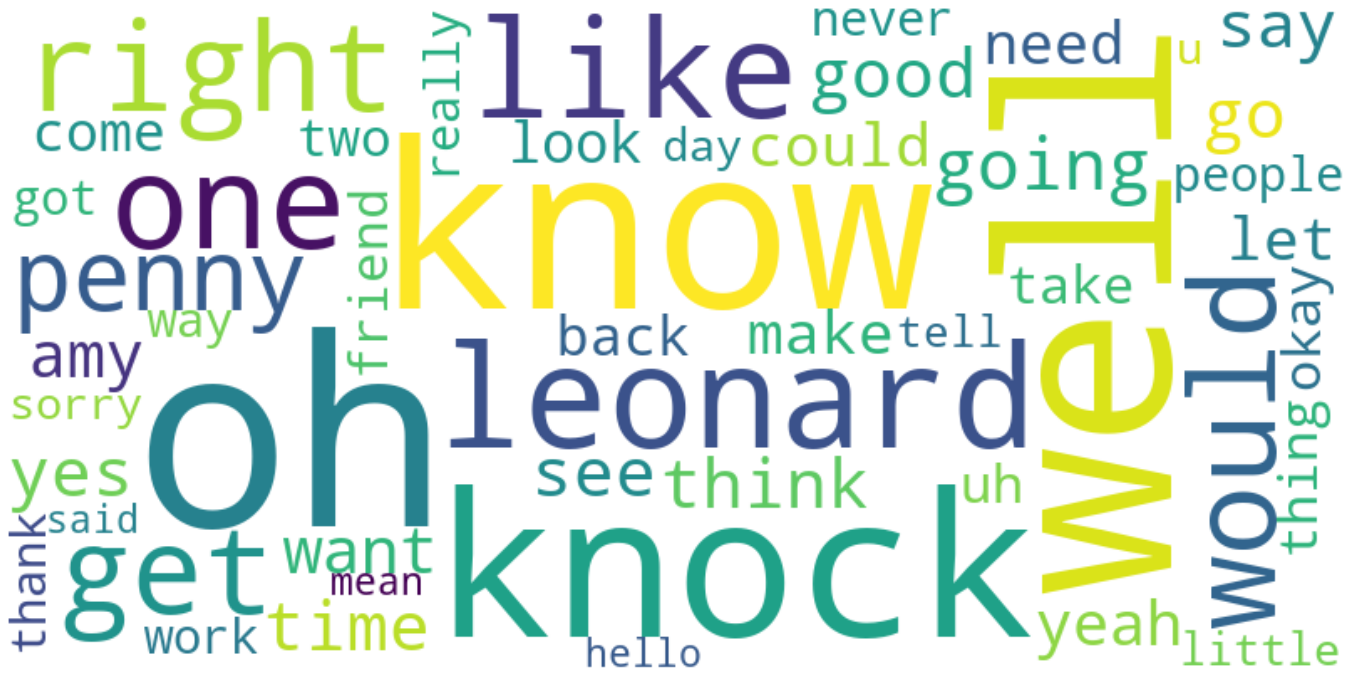

In [49]:
wc = WordCloud(width=800, height=400, max_words=50, background_color='white').generate_from_frequencies(sheldon_words)
plt.figure(figsize=(24,20))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [50]:
not_sheldon = df.loc[~(df['character'] == 'Sheldon')]

In [51]:
not_sheldon['dialogue'] = [word_tokenize(x) for x in not_sheldon['dialogue']]

<ipython-input-51-91adbf5f474e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  not_sheldon['dialogue'] = [word_tokenize(x) for x in not_sheldon['dialogue']]


In [52]:
not_sheldon_words = Counter()
not_sheldon['dialogue'].apply(not_sheldon_words.update)
not_sheldon_words.pop('’')
print(not_sheldon_words)

Counter({'oh': 3160, 'know': 2906, 'sheldon': 2388, 'okay': 2345, 'well': 2222, 'like': 2174, 'yeah': 2046, 'get': 1825, 'go': 1765, 'want': 1637, 'right': 1568, 'hey': 1424, 'think': 1355, 'apartment': 1319, 'one': 1306, 'got': 1250, 'really': 1243, 'going': 1213, 'leonard': 1209, 'penny': 1160, 'come': 1136, 'guy': 1126, 'good': 1119, 'na': 1052, 'look': 1046, 'gon': 1033, 'say': 1031, 'let': 1020, 'uh': 981, 'howard': 978, 'see': 936, 'would': 916, 'time': 904, 'little': 885, 'make': 873, 'thing': 822, 'could': 786, 'sorry': 784, 'back': 760, 'mean': 755, 'take': 706, 'tell': 691, 'great': 662, 'sure': 658, 'yes': 656, 'u': 655, 'need': 637, 'maybe': 626, 'raj': 610, 'something': 591, 'night': 573, 'thank': 567, 'bernadette': 544, 'love': 540, 'fine': 521, 'work': 520, 'way': 519, 'friend': 518, 'amy': 515, 'never': 503, 'two': 492, 'talk': 488, 'said': 463, 'kind': 462, 'nice': 452, 'girl': 452, 'people': 438, 'feel': 434, 'still': 422, 'put': 419, 'even': 418, 'much': 413, 'wait':

In [53]:
unique_words = []
for word in sheldon_words.keys():
    if word not in not_sheldon_words.keys():
        unique_words.append(word)

In [54]:
unique_words

['unobserved',
 'committing',
 'hostess',
 'fuddruckers',
 'yearn',
 'downloads',
 'clavicle',
 'evidently',
 'louis-slash-louise',
 'offline',
 'luncheon',
 'spoof',
 'bourne-oppenheimer',
 'restatement',
 'scribbled',
 'discouraging',
 'parallax',
 'distortion',
 'antisocial',
 'apparent',
 'hindered',
 'no-more-tears',
 'interruptus',
 'causality',
 'b.',
 'aforementioned',
 'query',
 'semi-rational',
 'proximal',
 'contradistinction',
 'distal',
 'arabic',
 'farsi',
 'intercom',
 'pantsing',
 'gastronomically',
 'mack',
 'thailand',
 'latter',
 'nineteenth',
 'interestingly',
 'pathology',
 'rife',
 'inaccuracy',
 'approximately',
 'sliced',
 'derives',
 'reflection',
 'dolly',
 'thou',
 'heartless',
 'congress',
 'hurt…',
 'mandelbrot',
 'chaos',
 'organisational',
 'flatware',
 'straightening',
 'swirling',
 'immaculate',
 'sssshhhh',
 'roused',
 'splendidly',
 'unorthodox',
 'enhancement',
 'otolaryngologist',
 'proctologist',
 'surgeon',
 'solely',
 'imposition',
 'disbelief',


In [55]:
len(unique_words)

5140

In [56]:
unique_words[100:]

['burner',
 'eliminating',
 'spelunking',
 'dumbed',
 'accommodate',
 'duration',
 'consonant',
 'plausible',
 'prefaced',
 'separation',
 'protein',
 'vis-a-vis',
 'greaseboards',
 'suffice',
 'evenly',
 'distributed',
 'amongst',
 'kow-tow',
 'weighs',
 '4,000lb',
 '4,400lb',
 'calliper',
 'aligned',
 'occupying',
 'buick',
 'mutilation',
 'put-put',
 'colourless',
 'workaday',
 'shelved',
 'multivitamin',
 'manganese',
 'bulk',
 'purchase',
 'inserted',
 'shhhhh',
 'mail-order',
 'temper',
 'rapture',
 'k-mart',
 'licquorish',
 'thirteen',
 'whatchacall',
 'fissionable',
 'uranium',
 'sonic',
 'pluck',
 'rocker',
 'lard',
 'spook',
 'silicon',
 'creator',
 'highness',
 'ass-kickings',
 'eluded',
 'mmm-hmm',
 'augmented',
 'battalion',
 'gettysburg',
 'aberration',
 'constitute',
 'manufacture',
 'semiotics',
 'linguistics',
 'courtship',
 'eclipse',
 'coincide',
 'gangster',
 'tampered',
 'beta-function',
 'chrono-dynamics',
 'uh-duh',
 'misjudged',
 'plantation',
 'foreseeable',
 '

# 2. Models

The main metric that I will use for comparing these models is the balanced accuracy. This is the arithmetic mean of the sensitivity and specificity.

## 2.1 Naive Bayes

### 2.1.1 Bag of Words

In [57]:
X = df['dialogue']
y = df['Sheldon']

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 25)

In [59]:
vectorizer = CountVectorizer(analyzer = "word",
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = None,
                             max_features = 200,
                             ngram_range = (1,2))

In [60]:
train_features = vectorizer.fit_transform(X_train)

In [61]:
train_features = train_features.toarray()

In [62]:
train_features.shape

(40803, 200)

In [63]:
gnb = GaussianNB()

In [64]:
X_train_pred_proba= gnb.fit(train_features, y_train).predict_proba(train_features)

In [65]:
cut_off = 0.25
X_train_pred = np.where(X_train_pred_proba[:,1]>cut_off,1,0)

In [66]:
train_accuracy = accuracy_score(y_train , X_train_pred)
train_accuracy

0.6791167316128716

In [67]:
metrics.precision_score(y_train, X_train_pred)

0.32856

In [68]:
metrics.recall_score(y_train, X_train_pred)

0.46633359827410015

In [69]:
metrics.balanced_accuracy_score(y_train, X_train_pred)

0.6020097795095967

In [70]:
test_features = vectorizer.transform(X_test)
test_features = test_features.toarray()

In [71]:
X_test_pred_proba= gnb.predict_proba(test_features)

In [72]:
X_test_pred = np.where(X_test_pred_proba[:,1]>cut_off,1,0)

In [73]:
test_accuracy = accuracy_score(y_test , X_test_pred)
test_accuracy

0.6782589515476803

In [74]:
metrics.precision_score(y_test, X_test_pred)

0.32771313227261933

In [75]:
metrics.recall_score(y_test, X_test_pred)

0.4717948717948718

In [76]:
metrics.balanced_accuracy_score(y_test, X_test_pred)

0.6033103246198038

### 2.1.2 TF-IDF

In [77]:
X = df['dialogue']
y = df['Sheldon']

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 25)

In [79]:
tfidf = TfidfVectorizer(max_features = 200, ngram_range = (1,2) )

In [80]:
train_features = tfidf.fit_transform(X_train)

In [81]:
train_features = train_features.toarray()

In [82]:
X_train_pred_proba= gnb.fit(train_features, y_train).predict_proba(train_features)

In [83]:
cut_off = 0.5
X_train_pred = np.where(X_train_pred_proba[:,1]>cut_off,1,0)

In [84]:
train_accuracy = accuracy_score(y_train , X_train_pred)
train_accuracy

0.6440457809474793

In [85]:
metrics.precision_score(y_train, X_train_pred)

0.320794934486866

In [86]:
metrics.recall_score(y_train, X_train_pred)

0.5810151016237084

In [87]:
metrics.balanced_accuracy_score(y_train, X_train_pred)

0.621205138010254

In [88]:
test_features = tfidf.transform(X_test)
test_features = test_features.toarray()

In [89]:
X_test_pred_proba= gnb.predict_proba(test_features)

In [90]:
X_test_pred = np.where(X_test_pred_proba[:,1]>cut_off,1,0)

In [91]:
test_accuracy = accuracy_score(y_test , X_test_pred)
test_accuracy

0.6409087567090656

In [92]:
metrics.precision_score(y_test, X_test_pred)

0.3164011246485473

In [93]:
metrics.recall_score(y_test, X_test_pred)

0.5770940170940171

In [94]:
metrics.balanced_accuracy_score(y_test, X_test_pred)

0.6177433367598224

So for the Naive Baysian model we have that both the bag of words method and TF-IDF method perform similarly.

## 2.2 Logistic Regression

### 2.2.1 Bag of Words

In [95]:
X = df['dialogue']
y = df['Sheldon']

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 25)

In [97]:
train_features = vectorizer.fit_transform(X_train)

In [98]:
vocab = vectorizer.get_feature_names()
#vocab

In [99]:
train_features = train_features.toarray()

In [100]:
lg_reg = sm.Logit(y_train, train_features).fit()


Optimization terminated successfully.
         Current function value: 0.547631
         Iterations 7


In [101]:
X_train_pred = lg_reg.predict(train_features)

In [102]:
cut_off = 0.31
X_train_pred_binary = np.where(X_train_pred>cut_off,1,0)

In [103]:
confusion = confusion_matrix(y_train, X_train_pred_binary)
confusion

array([[15257, 16739],
       [ 2373,  6434]], dtype=int64)

[Text(0.5, 0, 'Not Sheldon'), Text(1.5, 0, 'Sheldon')]

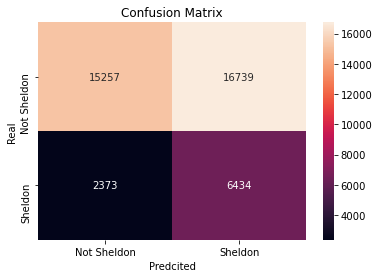

In [104]:
ax = plt.subplot()
sns.heatmap(confusion, annot=True, ax=ax, fmt='g')
ax.set_xlabel('Predcited')
ax.set_ylabel('Real')
ax.set_title('Confusion Matrix')
ax.yaxis.set_ticklabels(['Not Sheldon', 'Sheldon'])
ax.xaxis.set_ticklabels(['Not Sheldon', 'Sheldon'])

In [105]:
train_accuracy = accuracy_score(y_train , X_train_pred_binary)
train_accuracy

0.5316030684018332

In [106]:
metrics.precision_score(y_train, X_train_pred_binary)

0.2776507141932421

In [107]:
metrics.recall_score(y_train, X_train_pred_binary)

0.7305552401498808

In [108]:
metrics.balanced_accuracy_score(y_train, X_train_pred_binary)

0.6036980476283846

In [109]:
test_features = vectorizer.transform(X_test)
test_features = test_features.toarray()

In [110]:
X_test_pred = lg_reg.predict(test_features)

In [111]:
X_test_pred_binary = np.where(X_test_pred>cut_off,1,0)

In [112]:
test_accuracy = accuracy_score(y_test , X_test_pred_binary)
test_accuracy

0.5248143518858908

In [113]:
metrics.precision_score(y_test, X_test_pred_binary)

0.2722122070563997

In [114]:
metrics.recall_score(y_test, X_test_pred_binary)

0.7227350427350427

In [115]:
metrics.balanced_accuracy_score(y_test, X_test_pred_binary)

0.5966616390145802

### 2.2.2 TF-IDF

In [116]:
X = df['dialogue']
y = df['Sheldon']

In [117]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 25)

In [118]:
train_features = tfidf.fit_transform(X_train)

In [119]:
train_features = train_features.toarray()

In [120]:
lg_reg = sm.Logit(y_train, train_features).fit()

Optimization terminated successfully.
         Current function value: 0.520105
         Iterations 8


In [121]:
X_train_pred = lg_reg.predict(train_features)

In [122]:
cut_off = 0.23
X_train_pred_binary = np.where(X_train_pred>cut_off,1,0)

In [123]:
train_accuracy = accuracy_score(y_train , X_train_pred_binary)
train_accuracy

0.5330000245080019

In [124]:
metrics.precision_score(y_train, X_train_pred_binary)

0.2829733163913596

In [125]:
metrics.recall_score(y_train, X_train_pred_binary)

0.7586011127512207

In [126]:
metrics.balanced_accuracy_score(y_train, X_train_pred_binary)

0.614751862788912

In [127]:
test_features = tfidf.transform(X_test)
test_features = test_features.toarray()

In [128]:
X_test_pred = lg_reg.predict(test_features)

In [129]:
X_test_pred_binary = np.where(X_test_pred>cut_off,1,0)

In [130]:
test_accuracy = accuracy_score(y_test , X_test_pred_binary)
test_accuracy

0.5222410116903169

In [131]:
metrics.precision_score(y_test, X_test_pred_binary)

0.27400379506641365

In [132]:
metrics.recall_score(y_test, X_test_pred_binary)

0.7405128205128205

In [133]:
metrics.balanced_accuracy_score(y_test, X_test_pred_binary)

0.6014759681432593

For linear regression the TF-IDF method performed better, however it is still worse tha the performance of the Naive Baysian models.

## 2.3 SVM

In [134]:
# X = df['dialogue']
# y = df['Sheldon']

In [135]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 25)

In [136]:
# train_features = vectorizer.fit_transform(X_train)

In [137]:
# train_features = train_features.toarray()

In [138]:
# svm_model = SVC(gamma= 0.0001, kernel='rbf', C=500)
# svm_model.fit(train_features, y_train)

In [139]:
# train_pred = svm_model.predict(train_features)

In [140]:
# accuracy_score(y_train, train_pred)

In [141]:
# metrics.precision_score(y_train, train_pred)

In [142]:
# metrics.recall_score(y_train, train_pred)

In [143]:
# metrics.balanced_accuracy_score(y_train, train_pred)

In [144]:
# test_features = vectorizer.transform(X_test)
# test_features = test_features.toarray()

In [145]:
# test_pred = svm_model.predict(test_features)

In [146]:
# accuracy_score(y_test, test_pred)

In [147]:
# metrics.precision_score(y_test, test_pred)

In [148]:
# tuned_parameters = [
#                     {
#                         'kernel': ['rbf', 'linear'], 'gamma': [1e-3, 1e-4],'C': [100,250,500]
#                     }
#                     ]

In [149]:
# the_model = GridSearchCV(SVC(), tuned_parameters, scoring='accuracy',verbose =2)

In [150]:
# the_model.fit(train_features, y_train)

In [151]:
# the_model.best_params_

## 2.4 Random Forest

### 2.4.1 CountVectorizer

In [152]:
X = df['dialogue']
y = df['Sheldon']

In [153]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 25)

In [154]:
train_features = vectorizer.fit_transform(X_train)

In [155]:
train_features = train_features.toarray()

In [156]:
# tuned_parameters = [
#                     {
#                         'max_depth': [4,8,12], 'n_estimators': [250]
#                     }
#                     ]

In [157]:
# the_model = GridSearchCV(RandomForestClassifier(), tuned_parameters, scoring='balanced_accuracy', verbose = 2)

In [158]:
# the_model.fit(train_features, y_train)

In [159]:
# the_model.best_params_

In [160]:
rf = RandomForestClassifier(max_depth = 12, 
                            n_estimators=250)
rf.fit(train_features,y_train)

RandomForestClassifier(max_depth=12, n_estimators=250)

In [161]:
train_y_pred_proba = rf.predict_proba(train_features)

In [162]:
cut_off = 0.22
train_y_pred = np.where(train_y_pred_proba[:,1]>cut_off,1,0)

In [163]:
metrics.accuracy_score(y_train, train_y_pred)

0.694728328799353

In [164]:
metrics.precision_score(y_train, train_y_pred)

0.3613917799893641

In [165]:
metrics.recall_score(y_train, train_y_pred)

0.5401385261723629

In [166]:
metrics.balanced_accuracy_score(y_train, train_y_pred)

0.6387090930649288


Now to apply to test data

In [167]:
test_features = vectorizer.transform(X_test)
test_features = test_features.toarray()

In [168]:
test_y_pred_proba = rf.predict_proba(test_features)

In [169]:
test_y_pred = np.where(test_y_pred_proba[:,1]>cut_off,1,0)

In [170]:
metrics.accuracy_score(y_test, test_y_pred)

0.677964855525329

In [171]:
metrics.precision_score(y_test, test_y_pred)

0.33743016759776534

In [172]:
metrics.recall_score(y_test, test_y_pred)

0.5162393162393163

In [173]:
metrics.balanced_accuracy_score(y_test, test_y_pred)

0.6192567881308984

### 2.4.2 TF-IDF

In [174]:
X = df['dialogue']
y = df['Sheldon']

In [175]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 25)

In [176]:
train_features = tfidf.fit_transform(X_train)

In [177]:
train_features = train_features.toarray()

In [178]:
# tuned_parameters = [
#                     {
#                         'max_depth': [4,8,12], 'n_estimators': [250]
#                     }
#                     ]

In [179]:
# the_model = GridSearchCV(RandomForestClassifier(), tuned_parameters, scoring='balanced_accuracy', verbose = 2)

In [180]:
# the_model.fit(train_features, y_train)

In [181]:
# the_model.best_params_

In [182]:
rf = RandomForestClassifier(max_depth = 12, 
                            n_estimators=250)
rf.fit(train_features,y_train)

RandomForestClassifier(max_depth=12, n_estimators=250)

In [183]:
train_y_pred_proba = rf.predict_proba(train_features)

In [184]:
cut_off = 0.22
train_y_pred = np.where(train_y_pred_proba[:,1]>cut_off,1,0)

In [185]:
metrics.accuracy_score(y_train, train_y_pred)

0.6926206406391687

In [186]:
metrics.precision_score(y_train, train_y_pred)

0.36399388245575703

In [187]:
metrics.recall_score(y_train, train_y_pred)

0.5675031225161803

In [188]:
metrics.balanced_accuracy_score(y_train, train_y_pred)

0.6472813774851185

In [189]:
test_features = tfidf.transform(X_test)
test_features = test_features.toarray()

In [190]:
test_y_pred_proba = rf.predict_proba(test_features)

In [191]:
test_y_pred = np.where(test_y_pred_proba[:,1]>cut_off,1,0)

In [192]:
metrics.accuracy_score(y_test, test_y_pred)

0.6734798911844717

In [193]:
metrics.precision_score(y_test, test_y_pred)

0.33578856152513

In [194]:
metrics.recall_score(y_test, test_y_pred)

0.5299145299145299

In [195]:
metrics.balanced_accuracy_score(y_test, test_y_pred)

0.6213641589250432

Based on the above we can see that the Random Forest model outperforms both the logistic regression and the naive baysian models. Also basing our comparisions off the train scores we see that the TF-IDF model performs slightly better in terms of balanced accuracy score, it also has slightly better recall which would be our second metric to consider since we want to minimise type II errors.

# 3. Making the Function

Here I want to create a function that takes in a string of dialogue and returns wheather or not it is something Sheldon would say.

In [219]:
X = df['dialogue']
y = df['Sheldon']

In [220]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 25)

In [221]:
train_features = tfidf.fit_transform(X_train)

In [222]:
train_features = train_features.toarray()

In [223]:
rf = RandomForestClassifier(max_depth = 12, 
                            n_estimators=250)
rf.fit(train_features,y_train)

RandomForestClassifier(max_depth=12, n_estimators=250)

In [224]:
def sheldon_or_not(sentence):
    
    '''Takes in a string of dialogue and outputs wheather or not it is something 
    Sheldon from The Big Bang Theory would say'''
    
    #First clean the sentence, tokenize, remove stopwords, remove punctuation and lemmatize
    funct_df = pd.DataFrame([sentence],columns=['sentence'])
    funct_df['senetence'] = [" ".join(prep_data(x)) for x in funct_df['sentence']]
    
    #Now we nee to create the features using tf-idf from the train dataset
    features = tfidf.transform(funct_df['sentence'])
    features = features.toarray()
    #Now to make the prediction using the random forest model
    pred_proba = rf.predict_proba(features)
    cut_off = 0.22
    pred = np.where(pred_proba[:1]>cut_off,1,0)
    
    #This prediction is binary so now convert it to something understandable
    if pred[:,1][0] == 1:
        result = 'Sheldon'
    else:
        result = 'Not Sheldon'
        
    return result

In [225]:
tester = 'testing 1, 2, 3'

In [226]:
sheldon_or_not(tester)

'Not Sheldon'

# TDD

In [227]:
##sheldon
quote1 = 'I found the Grinch to be a relatable, engaging character, and I was really with him right up to the point \
        that he succumbed to social convention and returned the presents and saved Christmas. What a buzzkill that was.'
sheldon_or_not(quote1)

'Sheldon'

In [228]:
##sheldon
quote2 = "I am not crazy, my mother had me tested"
sheldon_or_not(quote2)

'Sheldon'

In [234]:
##sheldon
quote3 = "I am the smartest one in the room"
sheldon_or_not(quote3)

'Sheldon'

In [230]:
##not sheldon
quote4 = "I'm sorry"
sheldon_or_not(quote4)

'Not Sheldon'

In [231]:
##not sheldon
quote5 = "I don't have a clue"
sheldon_or_not(quote5)

'Not Sheldon'

In [232]:
##not sheldon
quote6 = "Let's go for a run outside"
sheldon_or_not(quote6)

'Not Sheldon'